In [1]:
# Import libraries and modules
import tensorflow as tf
import numpy as np
import shutil
print(tf.__version__)
print(np.__version__)
np.set_printoptions(threshold=np.inf)

1.15.2-dlenv_tfe
1.18.1


# Local Development

## Arguments

In [2]:
arguments = {}
# File arguments.
arguments["train_file_pattern"] = "data/train.tfrecord"
arguments["eval_file_pattern"] = "data/eval.tfrecord"
arguments["output_dir"] = "trained_model"

# Training parameters.
arguments["train_batch_size"] = 32
arguments["train_steps"] = 200

# Eval parameters.
arguments["eval_batch_size"] = 32
arguments["eval_steps"] = 100
arguments["start_delay_secs"] = 60
arguments["throttle_secs"] = 120

# Image parameters.
arguments["height"] = 32
arguments["width"] = 32
arguments["depth"] = 3

# Generator parameters.
arguments["latent_size"] = 512
arguments["generator_hidden_units"] = [2, 4, 8]
arguments["generator_l1_regularization_scale"] = 0.01
arguments["generator_l2_regularization_scale"] = 0.01
arguments["generator_optimizer"] = "Adam"
arguments["generator_learning_rate"] = 0.0001
arguments["generator_clip_gradients"] = 5.0
arguments["generator_train_steps"] = 40

# Discriminator hyperparameters.
arguments["discriminator_hidden_units"] = [8, 4, 2]
arguments["discriminator_l1_regularization_scale"] = 0.01
arguments["discriminator_l2_regularization_scale"] = 0.01
arguments["discriminator_optimizer"] = "Adam"
arguments["discriminator_learning_rate"] = 0.0001
arguments["discriminator_clip_gradients"] = 5.0
arguments["discriminator_train_steps"] = 25


## print_object.py

In [3]:
def print_obj(function_name, object_name, object_value):
    """Prints enclosing function, object name, and object value.

    Args:
        function_name: str, name of function.
        object_name: str, name of object.
        object_value: object, value of passed object.
    """
#     pass
    print("{}: {} = {}".format(function_name, object_name, object_value))


## input.py

In [4]:
def decode_example(protos, params):
    """Decodes TFRecord file into tensors.

    Given protobufs, decode into image and label tensors.

    Args:
        protos: protobufs from TFRecord file.
        params: dict, user passed parameters.

    Returns:
        Image and label tensors.
    """
    # Create feature schema map for protos.
    features = {
        "image_raw": tf.FixedLenFeature(shape=[], dtype=tf.string),
        "label": tf.FixedLenFeature(shape=[], dtype=tf.int64)
    }

    # Parse features from tf.Example.
    parsed_features = tf.parse_single_example(
        serialized=protos, features=features
    )
    print_obj("\ndecode_example", "features", features)

    # Convert from a scalar string tensor (whose single string has
    # length height * width * depth) to a uint8 tensor with shape
    # [height * width * depth].
    image = tf.decode_raw(
        input_bytes=parsed_features["image_raw"], out_type=tf.uint8
    )
    print_obj("decode_example", "image", image)

    # Reshape flattened image back into normal dimensions.
    image = tf.reshape(
        tensor=image,
        shape=[params["height"], params["width"], params["depth"]]
    )
    print_obj("decode_example", "image", image)

    # Convert from [0, 255] -> [-1.0, 1.0] floats.
    image = tf.cast(x=image, dtype=tf.float32) * (2. / 255) - 1.0
    print_obj("decode_example", "image", image)

    # Convert label from a scalar uint8 tensor to an int32 scalar.
    label = tf.cast(x=parsed_features["label"], dtype=tf.int32)
    print_obj("decode_example", "label", label)

    return {"image": image}, label


def read_dataset(filename, mode, batch_size, params):
    """Reads CSV time series data using tf.data, doing necessary preprocessing.

    Given filename, mode, batch size, and other parameters, read CSV dataset
    using Dataset API, apply necessary preprocessing, and return an input
    function to the Estimator API.

    Args:
        filename: str, file pattern that to read into our tf.data dataset.
        mode: The estimator ModeKeys. Can be TRAIN or EVAL.
        batch_size: int, number of examples per batch.
        params: dict, dictionary of user passed parameters.

    Returns:
        An input function.
    """
    def _input_fn():
        """Wrapper input function used by Estimator API to get data tensors.

        Returns:
            Batched dataset object of dictionary of feature tensors and label
                tensor.
        """
        # Create list of files that match pattern.
        file_list = tf.gfile.Glob(filename=filename)

        # Create dataset from file list.
        dataset = tf.data.TFRecordDataset(
            filenames=file_list, num_parallel_reads=40
        )

        # Shuffle and repeat if training with fused op.
        if mode == tf.estimator.ModeKeys.TRAIN:
            dataset = dataset.apply(
                tf.contrib.data.shuffle_and_repeat(
                    buffer_size=50 * batch_size,
                    count=None  # indefinitely
                )
            )

        # Decode CSV file into a features dictionary of tensors, then batch.
        dataset = dataset.apply(
            tf.contrib.data.map_and_batch(
                map_func=lambda x: decode_example(
                    protos=x,
                    params=params
                ),
                batch_size=batch_size,
                num_parallel_calls=4
            )
        )

        # Prefetch data to improve latency.
        dataset = dataset.prefetch(buffer_size=2)

        # Create a iterator, then get batch of features from example queue.
        batched_dataset = dataset.make_one_shot_iterator().get_next()

        return batched_dataset
    return _input_fn


## generator.py

In [5]:
def generator_network(Z, params, reuse=False):
    """Creates generator network and returns generated output.

    Args:
        Z: tensor, latent vectors of shape [cur_batch_size, latent_size].
        params: dict, user passed parameters.
        reuse: bool, whether to reuse variables or not.

    Returns:
        Generated outputs tensor of shape
            [cur_batch_size, height * width * depth].
    """
    # Create the input layer to our DNN.
    # shape = (cur_batch_size, latent_size)
    network = Z
    print_obj("\ngenerator_network", "network", network)

    # Create regularizer for dense layer kernel weights.
    regularizer = tf.contrib.layers.l1_l2_regularizer(
        scale_l1=params["generator_l1_regularization_scale"],
        scale_l2=params["generator_l2_regularization_scale"]
    )

    with tf.variable_scope("generator", reuse=reuse):
        # Add hidden layers with the given number of units/neurons per layer.
        for i, units in enumerate(params["generator_hidden_units"]):
            # shape = (cur_batch_size, generator_hidden_units[i])
            network = tf.layers.dense(
                inputs=network,
                units=units,
                activation=tf.nn.leaky_relu,
                kernel_regularizer=regularizer,
                name="layers_dense_{}".format(i)
            )
            print_obj("generator_network", "network", network)

        # Final linear layer for outputs.
        # shape = (cur_batch_size, height * width * depth)
        generated_outputs = tf.layers.dense(
            inputs=network,
            units=params["height"] * params["width"] * params["depth"],
            activation=None,
            kernel_regularizer=regularizer,
            name="layers_dense_generated_outputs"
        )
        print_obj("generator_network", "generated_outputs", generated_outputs)

    return generated_outputs


def get_generator_loss(generated_logits):
    """Gets generator loss.

    Args:
        generated_logits: tensor, shape of
            [cur_batch_size, height * width * depth].

    Returns:
        Tensor of generator's total loss of shape [].
    """
    # Calculate base generator loss.
    generator_loss = tf.reduce_mean(
        input_tensor=tf.nn.sigmoid_cross_entropy_with_logits(
            logits=generated_logits,
            labels=tf.ones_like(tensor=generated_logits)
        ),
        name="generator_loss"
    )
    print_obj(
        "\nget_generator_loss",
        "generator_loss",
        generator_loss
    )

    # Get regularization losses.
    generator_regularization_loss = tf.losses.get_regularization_loss(
        scope="generator",
        name="generator_regularization_loss"
    )
    print_obj(
        "get_generator_loss",
        "generator_regularization_loss",
        generator_regularization_loss
    )

    # Combine losses for total losses.
    generator_total_loss = tf.math.add(
        x=generator_loss,
        y=generator_regularization_loss,
        name="generator_total_loss"
    )
    print_obj(
        "get_generator_loss", "generator_total_loss", generator_total_loss
    )

    return generator_total_loss


## discriminator.py

In [6]:
def discriminator_network(X, params, reuse=False):
    """Creates discriminator network and returns logits.

    Args:
        X: tensor, image tensors of shape
            [cur_batch_size, height * width * depth].
        params: dict, user passed parameters.
        reuse: bool, whether to reuse variables or not.

    Returns:
        Logits tensor of shape [cur_batch_size, 1].
    """
    # Create the input layer to our DNN.
    # shape = (cur_batch_size, height * width * depth)
    network = X
    print_obj("\ndiscriminator_network", "network", network)

    # Create regularizer for dense layer kernel weights.
    regularizer = tf.contrib.layers.l1_l2_regularizer(
        scale_l1=params["discriminator_l1_regularization_scale"],
        scale_l2=params["discriminator_l2_regularization_scale"]
    )

    with tf.variable_scope("discriminator", reuse=reuse):
        # Add hidden layers with the given number of units/neurons per layer.
        for i, units in enumerate(params["discriminator_hidden_units"]):
            # shape = (cur_batch_size, discriminator_hidden_units[i])
            network = tf.layers.dense(
                inputs=network,
                units=units,
                activation=tf.nn.leaky_relu,
                kernel_regularizer=regularizer,
                name="layers_dense_{}".format(i)
            )
            print_obj("discriminator_network", "network", network)

        # Final linear layer for logits.
        # shape = (cur_batch_size, 1)
        logits = tf.layers.dense(
            inputs=network,
            units=1,
            activation=None,
            kernel_regularizer=regularizer,
            name="layers_dense_logits"
        )
        print_obj("discriminator_network", "logits", logits)

    return logits


def get_discriminator_loss(generated_logits, real_logits):
    """Gets discriminator loss.

    Args:
        generated_logits: tensor, shape of
            [cur_batch_size, height * width * depth].
        real_logits: tensor, shape of
            [cur_batch_size, height * width * depth].

    Returns:
        Tensor of discriminator's total loss of shape [].
    """
    # Calculate base discriminator loss.
    discriminator_real_loss = tf.nn.sigmoid_cross_entropy_with_logits(
        logits=real_logits,
        labels=tf.ones_like(tensor=real_logits),
        name="discriminator_real_loss"
    )
    print_obj(
        "\nget_discriminator_loss",
        "discriminator_real_loss",
        discriminator_real_loss
    )

    discriminator_generated_loss = tf.nn.sigmoid_cross_entropy_with_logits(
        logits=generated_logits,
        labels=tf.zeros_like(tensor=generated_logits),
        name="discriminator_generated_loss"
    )
    print_obj(
        "get_discriminator_loss",
        "discriminator_generated_loss",
        discriminator_generated_loss
    )

    discriminator_loss = tf.reduce_mean(
        input_tensor=tf.add(
            x=discriminator_real_loss, y=discriminator_generated_loss
        ),
        name="discriminator_loss"
    )
    print_obj(
        "get_discriminator_loss",
        "discriminator_loss",
        discriminator_loss
    )

    # Get regularization losses.
    discriminator_regularization_loss = tf.losses.get_regularization_loss(
        scope="discriminator",
        name="discriminator_regularization_loss"
    )
    print_obj(
        "get_discriminator_loss",
        "discriminator_regularization_loss",
        discriminator_regularization_loss
    )

    # Combine losses for total losses.
    discriminator_total_loss = tf.math.add(
        x=discriminator_loss,
        y=discriminator_regularization_loss,
        name="discriminator_total_loss"
    )
    print_obj(
        "get_discriminator_loss",
        "discriminator_total_loss",
        discriminator_total_loss
    )

    return discriminator_total_loss


## vanilla_gan.py

In [7]:
def train_network(loss, global_step, params, scope):
    """Trains network and returns loss and train op.

    Args:
        loss: tensor, shape of [].
        global_step: tensor, the current training step or batch in the
            training loop.
        params: dict, user passed parameters.
        scope: str, the variables that to train.

    Returns:
        Loss tensor and training op.
    """
    # Create optimizer map.
    optimizers = {
        "Adam": tf.train.AdamOptimizer,
        "Adadelta": tf.train.AdadeltaOptimizer,
        "AdagradDA": tf.train.AdagradDAOptimizer,
        "Adagrad": tf.train.AdagradOptimizer,
        "Ftrl": tf.train.FtrlOptimizer,
        "GradientDescent": tf.train.GradientDescentOptimizer,
        "Momentum": tf.train.MomentumOptimizer,
        "ProximalAdagrad": tf.train.ProximalAdagradOptimizer,
        "ProximalGradientDescent": tf.train.ProximalGradientDescentOptimizer,
        "RMSProp": tf.train.RMSPropOptimizer
    }

    # Get gradients.
    gradients = tf.gradients(
        ys=loss,
        xs=tf.trainable_variables(scope=scope),
        name="{}_gradients".format(scope)
    )

    # Clip gradients.
    if params["{}_clip_gradients".format(scope)]:
        gradients, _ = tf.clip_by_global_norm(
            t_list=gradients,
            clip_norm=params["{}_clip_gradients".format(scope)],
            name="{}_clip_by_global_norm_gradients".format(scope)
        )

    # Zip back together gradients and variables.
    grads_and_vars = zip(gradients, tf.trainable_variables(scope=scope))

    # Get optimizer and instantiate it.
    optimizer = optimizers[params["{}_optimizer".format(scope)]](
        learning_rate=params["{}_learning_rate".format(scope)]
    )

    # Create train op by applying gradients to variables and incrementing
    # global step.
    train_op = optimizer.apply_gradients(
        grads_and_vars=grads_and_vars,
        global_step=global_step,
        name="{}_apply_gradients".format(scope)
    )

    return loss, train_op


def vanilla_gan_model(features, labels, mode, params):
    """Vanilla GAN custom Estimator model function.

    Args:
        features: dict, keys are feature names and values are feature tensors.
        labels: tensor, label data.
        mode: tf.estimator.ModeKeys with values of either TRAIN, EVAL, or
            PREDICT.
        params: dict, user passed parameters.

    Returns:
        Instance of `tf.estimator.EstimatorSpec` class.
    """
    print_obj("\nvanilla_gan_model", "features", features)
    print_obj("vanilla_gan_model", "labels", labels)
    print_obj("vanilla_gan_model", "mode", mode)
    print_obj("vanilla_gan_model", "params", params)

    # Loss function, training/eval ops, etc.
    predictions_dict = None
    loss = None
    train_op = None
    eval_metric_ops = None
    export_outputs = None

    if mode == tf.estimator.ModeKeys.PREDICT:
        # Extract given latent vectors from features dictionary.
        Z = tf.cast(x=features["Z"], dtype=tf.float32)

        # Establish generator network subgraph.
        generator_outputs = generator_network(Z, params, reuse=False)

        generated_images = tf.reshape(
            tensor=generator_outputs,
            shape=[-1, params["height"], params["width"], params["depth"]]
        )

        # Create predictions dictionary.
        predictions_dict = {
            "generated_images": generated_images
        }

        # Create export outputs.
        export_outputs = {
            "predict_export_outputs": tf.estimator.export.PredictOutput(
                outputs=predictions_dict)
        }
    else:
        # Extract image from features dictionary.
        X = tf.reshape(
            tensor=features["image"],
            shape=[-1, params["height"] * params["width"] * params["depth"]]
        )

        # Get dynamic batch size in case of partial batch.
        cur_batch_size = tf.shape(
            input=X,
            out_type=tf.int32,
            name="vanilla_gan_model_cur_batch_size"
        )[0]

        # Create random noise latent vector for each batch example.
        Z = tf.random.normal(
            shape=[cur_batch_size, params["latent_size"]],
            mean=0.0,
            stddev=1.0,
            dtype=tf.float32
        )

        # Establish generator network subgraph.
        generator_outputs = generator_network(Z, params, reuse=False)

        # Establish discriminator network subgraph.
        real_logits = discriminator_network(X, params, reuse=False)

        # Get generated logits too.
        generated_logits = discriminator_network(
            generator_outputs, params, reuse=True
        )

        # Get generator total loss.
        generator_total_loss = get_generator_loss(generated_logits)

        # Get discriminator total loss.
        discriminator_total_loss = get_discriminator_loss(
            generated_logits, real_logits
        )

        if mode == tf.estimator.ModeKeys.TRAIN:
            # Get global step.
            global_step = tf.train.get_global_step()

            # Determine if it is time to train generator or discriminator.
            cycle_step = tf.mod(
                x=global_step,
                y=tf.cast(
                    x=tf.add(
                        x=params["generator_train_steps"],
                        y=params["discriminator_train_steps"]
                    ),
                    dtype=tf.int64
                )
            )

            # Create choose generator condition.
            condition = tf.less(
                x=cycle_step, y=params["generator_train_steps"]
            )

            # Conditionally choose to train generator or discriminator subgraph.
            loss, train_op = tf.cond(
                pred=condition,
                true_fn=lambda: train_network(
                    loss=generator_total_loss,
                    global_step=global_step,
                    params=params,
                    scope="generator"
                ),
                false_fn=lambda: train_network(
                    loss=discriminator_total_loss,
                    global_step=global_step,
                    params=params,
                    scope="discriminator"
                )
            )
        else:
            loss = discriminator_total_loss

            # Concatenate discriminator logits and labels.
            discriminator_logits = tf.concat(
                values=[real_logits, generated_logits],
                axis=0,
                name="discriminator_concat_logits"
            )

            discriminator_labels = tf.concat(
                values=[
                    tf.ones_like(tensor=real_logits),
                    tf.zeros_like(tensor=generated_logits)
                ],
                axis=0,
                name="discriminator_concat_labels"
            )

            # Calculate discriminator probabilities.
            discriminator_probabilities = tf.nn.sigmoid(
                x=discriminator_logits, name="discriminator_probabilities"
            )

            # Create eval metric ops dictionary.
            eval_metric_ops = {
                "accuracy": tf.metrics.accuracy(
                    labels=discriminator_labels,
                    predictions=discriminator_probabilities,
                    name="vanilla_gan_model_accuracy"
                ),
                "precision": tf.metrics.precision(
                    labels=discriminator_labels,
                    predictions=discriminator_probabilities,
                    name="vanilla_gan_model_precision"
                ),
                "recall": tf.metrics.recall(
                    labels=discriminator_labels,
                    predictions=discriminator_probabilities,
                    name="vanilla_gan_model_recall"
                ),
                "auc_roc": tf.metrics.auc(
                    labels=discriminator_labels,
                    predictions=discriminator_probabilities,
                    num_thresholds=200,
                    curve="ROC",
                    name="vanilla_gan_model_auc_roc"
                ),
                "auc_pr": tf.metrics.auc(
                    labels=discriminator_labels,
                    predictions=discriminator_probabilities,
                    num_thresholds=200,
                    curve="PR",
                    name="vanilla_gan_model_auc_pr"
                )
            }

    # Return EstimatorSpec
    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=predictions_dict,
        loss=loss,
        train_op=train_op,
        eval_metric_ops=eval_metric_ops,
        export_outputs=export_outputs
    )


## serving.py

In [8]:
def serving_input_fn(params):
    """Serving input function.

    Args:
        params: dict, user passed parameters.

    Returns:
        ServingInputReceiver object containing features and receiver tensors.
    """
    # Create placeholders to accept data sent to the model at serving time.
    # shape = (batch_size,)
    feature_placeholders = {
        "Z": tf.placeholder(
            dtype=tf.float32,
            shape=[None, params["latent_size"]],
            name="serving_input_placeholder_Z"
        )
    }

    print_obj(
        "serving_input_fn",
        "feature_placeholders",
        feature_placeholders
    )

    # Create clones of the feature placeholder tensors so that the SavedModel
    # SignatureDef will point to the placeholder.
    features = {
        key: tf.identity(
            input=value,
            name="serving_input_fn_identity_placeholder_{}".format(key)
        )
        for key, value in feature_placeholders.items()
    }

    print_obj(
        "serving_input_fn",
        "features",
        features
    )

    return tf.estimator.export.ServingInputReceiver(
        features=features, receiver_tensors=feature_placeholders
    )


## model.py

In [9]:
def train_and_evaluate(args):
    """Trains and evaluates custom Estimator model.

    Args:
        args: dict, user passed parameters.

    Returns:
        `Estimator` object.
    """
    # Set logging to be level of INFO.
    tf.logging.set_verbosity(tf.logging.INFO)

    # Create our custom estimator using our model function.
    estimator = tf.estimator.Estimator(
        model_fn=vanilla_gan_model,
        model_dir=args["output_dir"],
        params=args
    )

    # Create train spec to read in our training data.
    train_spec = tf.estimator.TrainSpec(
        input_fn=read_dataset(
            filename=args["train_file_pattern"],
            mode=tf.estimator.ModeKeys.TRAIN,
            batch_size=args["train_batch_size"],
            params=args
        ),
        max_steps=args["train_steps"]
    )

    # Create exporter to save out the complete model to disk.
    exporter = tf.estimator.LatestExporter(
        name="exporter",
        serving_input_receiver_fn=lambda: serving_input_fn(args)
    )

    # Create eval spec to read in our validation data and export our model.
    eval_spec = tf.estimator.EvalSpec(
        input_fn=read_dataset(
            filename=args["eval_file_pattern"],
            mode=tf.estimator.ModeKeys.EVAL,
            batch_size=args["eval_batch_size"],
            params=args
        ),
        steps=args["eval_steps"],
        start_delay_secs=args["start_delay_secs"],
        throttle_secs=args["throttle_secs"],
        exporters=exporter
    )

    # Create train and evaluate loop to train and evaluate our estimator.
    tf.estimator.train_and_evaluate(
        estimator=estimator, train_spec=train_spec, eval_spec=eval_spec)

    return estimator


## Run model

In [10]:
shutil.rmtree(path=arguments["output_dir"], ignore_errors=True)
estimator = train_and_evaluate(arguments)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'trained_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3335751890>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tens

## Prediction

In [11]:
!ls trained_model/export/exporter

1590989625


In [12]:
predict_fn = tf.contrib.predictor.from_saved_model(
    "trained_model/export/exporter/1590989625"
)
predictions = predict_fn(
    {
        "Z": np.random.normal(size=(500, 512))
    }
)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from trained_model/export/exporter/1590989625/variables/variables


Convert image back to the original scale.

In [13]:
generated_images = np.clip(
    a=((predictions["generated_images"] + 1.0) * (255. / 2)).astype(np.int32),
    a_min=0,
    a_max=255
)

In [14]:
print(generated_images.shape)

(500, 32, 32, 3)


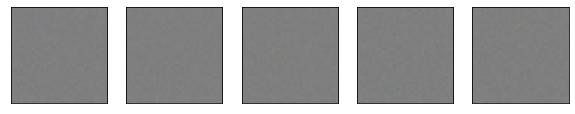

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(generated_images[i], cmap=plt.cm.binary)
plt.show()